In [64]:
import numpy as np
import json
import matplotlib.pyplot as plt
BASE_PATH = "/home/epiper/SysML/SysMLTeam12/per-layer-experiment-4"

In [65]:
test_arr = np.load(BASE_PATH + f"/batch_{1}/layer_{3}/saved_models/bert_base-SST-2-two_stage/accLat_1_1.0.npy", allow_pickle=True)
test_arr

array([{1: 0, 2: 0, 3: 872, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0},
       {1: 0, 2: 0, 3: 0.0035073415401878708, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0},
       0.25, {3: np.float64(0.7855504587155964)}], dtype=object)

Each element in data_tuple is `[[entropies], exit_layer, eval_time, int(is_correct)]`

In [66]:
json_file = BASE_PATH + f"/batch_{1}/layer_{1}/layer_metrics.json"

with open(json_file, 'r') as file:
    data = json.load(file)

data['data_tuple'][0]

[[0.4994431138038635], 1, 0.18363142013549805, 1]

In [105]:
batch_sizes = np.array([1, 2, 4, 8, 16])
layers = np.arange(12) + 1

batch_time_data = {}
batch_mean_std_data = {}

for batch in batch_sizes:
    cur_eval_times = []
    cur_eval_std = []
    for layer in layers:
        cur_json_path = BASE_PATH + f"/batch_{batch}/layer_{layer}/layer_metrics.json"
        data = None
        with open(cur_json_path, 'r') as file:
            data = json.load(file)
        eval_times = [elem[2] for elem in data["data_tuple"]][1:] # exclude index 0 because it's always an outlier
        eval_times = np.array(eval_times)
        eval_times = eval_times[eval_times >= 0] # some of the values are really negative fro some reason
        # cur_eval_times.append(float(np.percentile(eval_times, 95)) * 1000)
        cur_eval_times.append(float(np.mean(eval_times * 1e9)))
        cur_eval_std.append(float(np.std(eval_times * 1e9)))

    batch_dict = {"mean": cur_eval_times, "std": cur_eval_std}
    batch_mean_std_data[int(batch)] = batch_dict
    batch_time_data[int(batch)] = cur_eval_times

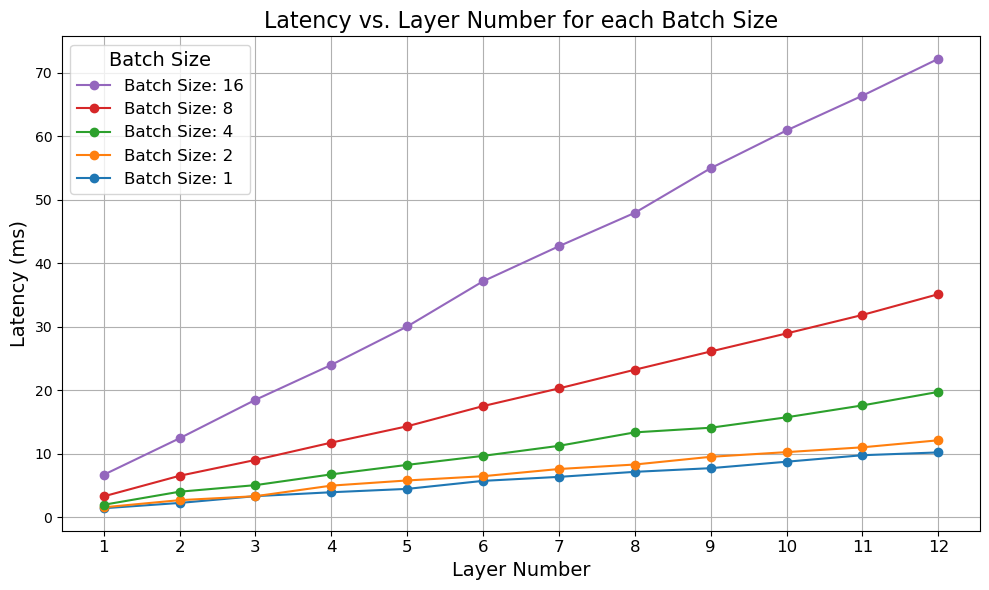

In [79]:
plt.figure(figsize=(10, 6))
lines = []
labels = []
for batch_size, times in batch_time_data.items():
    line, = plt.plot(range(1, len(times) + 1), times, label=f'Batch size {batch_size}', marker='o')
    lines.append(line)
    labels.append(f'Batch Size: {batch_size}')

# Ensure all x-axis ticks from 1 to 12 appear
plt.xticks(range(1, 13), fontsize=12)

# Reverse the order of legend entries
plt.legend(lines[::-1], labels[::-1], title='Batch Size', fontsize=12, title_fontsize=14)

plt.title('Latency vs. Layer Number for each Batch Size', fontsize=16)
plt.xlabel('Layer Number', fontsize=14)
plt.ylabel('Latency (ms)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

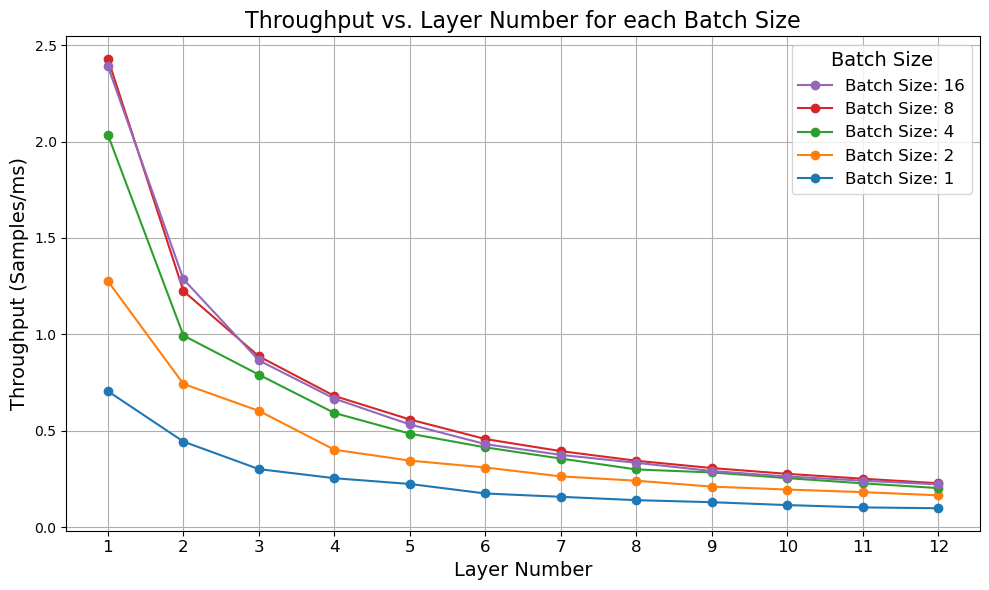

In [80]:
plt.figure(figsize=(10, 6))
lines = []
labels = []
for batch_size, times in batch_time_data.items():
    throughput = np.array(times)
    throughput = batch_size / throughput
    line, = plt.plot(range(1, len(times) + 1), throughput, label=f'Batch size {batch_size}', marker='o')
    lines.append(line)
    labels.append(f'Batch Size: {batch_size}')

# Ensure all x-axis ticks from 1 to 12 appear
plt.xticks(range(1, 13), fontsize=12)

# Reverse the order of legend entries
plt.legend(lines[::-1], labels[::-1], title='Batch Size', fontsize=12, title_fontsize=14)

plt.title('Throughput vs. Layer Number for each Batch Size', fontsize=16)
plt.xlabel('Layer Number', fontsize=14)
plt.ylabel('Throughput (Samples/ms)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

{
    "id": 0,
    "accuracy": 69.758,
    "constraint_mflop": 0,
    "filename": "resnet18.pt",
    "latency_and_batch_ns": [
        {
            "batch_size": 1,
            "mean": 3111316.4024,
            "std": 85912.43312104151
        },
        {
            "batch_size": 2,
            "mean": 2783858.3348,
            "std": 54916.5085566619
        },
        {
            "batch_size": 4,
            "mean": 3805301.9076,
            "std": 206342.0438090311
        },
        {
            "batch_size": 8,
            "mean": 3916172.4652,
            "std": 165075.91118808615
        },
        {
            "batch_size": 16,
            "mean": 5704938.6588,
            "std": 280758.66743754543
        },
        {
            "batch_size": 32,
            "mean": 10096838.1,
            "std": 128052.63361336487
        }
    ],
    "loading_time_ns": 9883379.2074,
    "predicted_accuracy": -1,
    "predicted_mflops": -1
}

In [99]:
e_thres = {
    1: 1,
    2: 0.6,
    3: 0.6,
    4: 0.2,
    5: 0.2,
    6: 0.2,
    7: 0.2,
    8: 0.2,
    9: 0.01,
    10: 0,
    11: 0,
    12: 0,
}


accuracy = {1: 0.7373853211009175,
 2: 0.7786697247706422,
 3: 0.7844036697247706,
 4: 0.7889908256880734,
 5: 0.7970183486238532,
 6: 0.8394495412844036,
 7: 0.8589449541284404,
 8: 0.8772935779816514,
 9: 0.9036697247706422,
 10: 0.9151376146788991,
 11: 0.9139908256880734,
 12: 0.9174311926605505}

In [115]:
new_json_profile = {}
models = []
batch_sizes = np.array([1, 2, 4, 8, 16])

layers = np.arange(12) + 1

for layer in layers:
    e_val = e_thres[layer]
    e_vec = [e_val] * (layer-1) + [1] + [0] * (12 - layer)
    new_model = {"id": int(layer), "note": "Id is just the layer we will use", "accuray": round(accuracy[layer], 4), "entropy_vector": e_vec,"filename": "???"}
    latency_batch = []
    for batch in batch_sizes:
        new_batch_data = {"batch_size": int(batch), "mean": batch_mean_std_data[batch]["mean"][layer-1], "std": batch_mean_std_data[batch]["std"][layer-1]}
        latency_batch.append(new_batch_data)
    new_model["latency_and_batch_ns"] = latency_batch
    models.append(new_model)
new_json_profile["models"] = models
new_json_profile

{'models': [{'id': 1,
   'note': 'Id is just the layer we will use',
   'accuray': 0.7374,
   'entropy_vector': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   'filename': '???',
   'latency_and_batch_ns': [{'batch_size': 1,
     'mean': 1418528.682739398,
     'std': 447461.90173714055},
    {'batch_size': 2, 'mean': 1567918.4047655128, 'std': 302077.0345965384},
    {'batch_size': 4, 'mean': 1966205.060756701, 'std': 335372.2189647379},
    {'batch_size': 8, 'mean': 3293478.9304380063, 'std': 469907.6924591704},
    {'batch_size': 16, 'mean': 6695588.42976888, 'std': 706925.7067938288}]},
  {'id': 2,
   'note': 'Id is just the layer we will use',
   'accuray': 0.7787,
   'entropy_vector': [0.6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   'filename': '???',
   'latency_and_batch_ns': [{'batch_size': 1,
     'mean': 2254395.479449722,
     'std': 573775.2052204972},
    {'batch_size': 2, 'mean': 2693417.4285537894, 'std': 1006150.9053437415},
    {'batch_size': 4, 'mean': 4025498.8428634433, 'std': 

In [116]:
# Writing the dictionary to a JSON file
with open("batch_data.json", "w") as file:
    json.dump(new_json_profile, file, indent=4)  # 'indent' makes the file human-readable